# Deep Learning - Day 2 - How to properly prevent overfitting

### Exercise objectives:
- Give a validation set to the model
- Use the stopping criterion to prevent the Neural network from overfitting

<hr>
<hr>

Yesterday, not everything was done properly, so let's get back to that.

# Data 

First, let's generate some data thanks to the [`make_blob`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function that we used yesterday.

❓ **Question** ❓ Generate 2000 samples, with 10 features each. There should be 8 classes of blobs (`centers` argument), wich `cluster_std` equal to 7. Plot some dimensions to check your data.

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X, y = make_blobs(n_samples=2000, centers=8, n_features=10, cluster_std=7)
X.shape, y.shape

((2000, 10), (2000,))

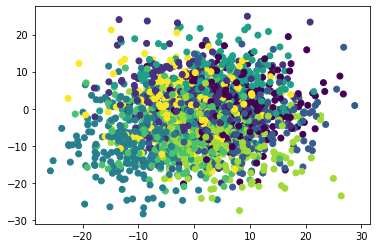

In [3]:
plt.scatter(X.T[0], X.T[1], c = y)

❓ **Question** ❓ Use the `to_categorical` function from `tensorflow` to convert `y` to `y_cat` which is the categorical representation of `y` with one-hot encoding columns.

In [4]:
from tensorflow.keras.utils import to_categorical 

y_cat = to_categorical(y)
y_cat.shape

(2000, 8)


# Part I : Valid cross-validation

Yesterday, we splitted the dataset into a train and a test set at the beginning of the notebook. And then, we started to build different models which were trained on the train set but evaluated on the test set.

So, at the end of the day, we used the test set as many times as we evaluated our models and different hyperparameters. We therefore _used_ the test set to select our best model. Which is a sort of overfitting, as we were not able to properly state whether our best model was best on any unseen data or only on the test set which was used to select our model. 

A first good practice is to avoid using `random_state` or any deterministic separation between your train and test set. In that case, your test set will change everytime you re-run your notebook. But this is far from being sufficient.

To properly compare models, you have to run a proper cross-validation, a 10-fold split for instance. Let's see how to do it properly.

❓ **Question** ❓ First, write a function that outputs a neural network with 3 layers
- a layer with 25 neurons, the `relu` activation function and the appropriate `input_dim`
- a layer with 10 neurons and the `relu` activation function.
- a last layer which is suited to the problem at hand (multiclass classification)

The function should include its compilation, with the `categorical_crossentropy` loss, the `adam` optimizer and the `accuracy` metrics.

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers


def initialize_model():
    model = models.Sequential()
    model.add(layers.Dense(25, input_dim=10, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
model = initialize_model

Here, we will do a proper cross validation.

❓ **Question** ❓ Write a loop thanks to the [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function of Scikit-Learn (select 10 splits) to fit your model on the train data, and evaluate it on the test data. Store the result of the evaluation in the `results` variable.

Do not forget to standardize your train data before fitting the neural network.
Also, 150 epochs shoul be sufficient in a first approximation

In [19]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

kf = KFold(n_splits=10)
kf.get_n_splits(X)

results = []

for train_index, test_index in kf.split(X):
    ### Split the data into train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_cat[train_index], y_cat[test_index]
    
    ### Use the standard scaler
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    ### Initialize the model
    model = initialize_model()
    
    ### Fit the model on the train data
    history = model.fit(X_train, y_train, 
                    epochs=2, 
                    batch_size=16, 
                    verbose=1)
    
#     # Evaluate the model on the test data and append the result in the `results` variable
    results.append(model.evaluate(X_test, y_test)[1])
    
results


Epoch 1/2
113/113 [==============================] - 0s 1ms/step - loss: 1.9163 - accuracy: 0.2828
Epoch 2/2
113/113 [==============================] - 0s 1ms/step - loss: 1.5205 - accuracy: 0.4567
Epoch 1/2
113/113 [==============================] - 0s 1ms/step - loss: 1.9059 - accuracy: 0.2356
Epoch 2/2
113/113 [==============================] - 0s 1ms/step - loss: 1.5499 - accuracy: 0.4828
Epoch 1/2
113/113 [==============================] - 0s 1ms/step - loss: 1.8430 - accuracy: 0.3444
Epoch 2/2
113/113 [==============================] - 0s 1ms/step - loss: 1.4026 - accuracy: 0.5994
Epoch 1/2
113/113 [==============================] - 0s 1ms/step - loss: 1.9767 - accuracy: 0.2267
Epoch 2/2
113/113 [==============================] - 0s 1ms/step - loss: 1.6088 - accuracy: 0.4378
Epoch 1/2
113/113 [==============================] - 0s 1ms/step - loss: 1.9370 - accuracy: 0.2378
Epoch 2/2
113/113 [==============================] - 0s 1ms/step - loss: 1.5554 - accuracy: 0.4628
Epoch 1/2


In [15]:
results

[0.7649999856948853,
 0.7749999761581421,
 0.7450000047683716,
 0.7599999904632568,
 0.7250000238418579,
 0.8050000071525574,
 0.7900000214576721,
 0.800000011920929,
 0.800000011920929,
 0.8050000071525574]

❓ **Question** ❓ Print the mean accuracy, and its standard deviation

In [17]:
results = np.array(results)
print('mean = ',results.mean())
print('std = ',results.std())

mean =  0.7770000040531159
std =  0.026381812738938075


❗ **Remark** ❗ You probably encountered one of the drawback of using a proper cross-validation for a neural network: **it takes a lot of time**. Therefore, for the rest of week, we will do **only one split**. But remember that this is not entirely correct and, for real-life applications and problems, you are encouraged to use a proper cross-validation technique.

❗ **Remark** ❗ In general, what practitionners do, is that they split only once, as you did. And once they get to the end of their optimization, they launch a real cross-validation at 6pm, go home and get the final results on the next day.

❓ **Question** ❓ For the rest of the exercise (and you will do the same for the rest of the week), split the dataset into train and test with a 70/30% training to test data ratio.



In [18]:
n_train = int(0.5*len(X))

X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y_cat[:n_train], y_cat[n_train:]

In [20]:
### Use the standard scaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Part II : Stop the learning before overfitting

Let's first show that if we train the model for too long, it will overfit the training data and will not be good on the test data.

❓ **Question** ❓ To do that, train the same neural network (do not forget to re-initialize it) with `validation_data=(X_test, y_test)` and 500 epochs. Store the history in the `history` variable.

In [29]:
### Initialize the model
model = initialize_model()

### Fit the model on the train data
history = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=500, 
                batch_size=16, 
                verbose=1)

Epoch 1/500
113/113 [==============================] - 0s 2ms/step - loss: 1.9314 - accuracy: 0.2561 - val_loss: 1.7723 - val_accuracy: 0.4000
Epoch 2/500
113/113 [==============================] - 0s 2ms/step - loss: 1.4989 - accuracy: 0.5250 - val_loss: 1.3207 - val_accuracy: 0.5800
Epoch 3/500
113/113 [==============================] - 0s 2ms/step - loss: 1.0413 - accuracy: 0.7044 - val_loss: 0.9538 - val_accuracy: 0.6850
Epoch 4/500
113/113 [==============================] - 0s 2ms/step - loss: 0.7819 - accuracy: 0.7611 - val_loss: 0.7791 - val_accuracy: 0.7350
Epoch 5/500
113/113 [==============================] - 0s 2ms/step - loss: 0.6573 - accuracy: 0.7828 - val_loss: 0.6942 - val_accuracy: 0.7500
Epoch 6/500
113/113 [==============================] - 0s 2ms/step - loss: 0.5957 - accuracy: 0.7911 - val_loss: 0.6542 - val_accuracy: 0.7800
Epoch 7/500
113/113 [==============================] - 0s 1ms/step - loss: 0.5621 - accuracy: 0.8083 - val_loss: 0.6379 - val_accuracy: 0.7900

Epoch 58/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3979 - accuracy: 0.8533 - val_loss: 0.6033 - val_accuracy: 0.8000
Epoch 59/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3944 - accuracy: 0.8533 - val_loss: 0.5928 - val_accuracy: 0.8000
Epoch 60/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3957 - accuracy: 0.8500 - val_loss: 0.5951 - val_accuracy: 0.8050
Epoch 61/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3956 - accuracy: 0.8533 - val_loss: 0.5823 - val_accuracy: 0.8050
Epoch 62/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3948 - accuracy: 0.8522 - val_loss: 0.5986 - val_accuracy: 0.8150
Epoch 63/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3916 - accuracy: 0.8522 - val_loss: 0.5998 - val_accuracy: 0.7800
Epoch 64/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3944 - accuracy: 0.8533 - val_loss: 0.5935 - val_accuracy:

Epoch 115/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3610 - accuracy: 0.8661 - val_loss: 0.6536 - val_accuracy: 0.7950
Epoch 116/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3640 - accuracy: 0.8661 - val_loss: 0.6365 - val_accuracy: 0.7850
Epoch 117/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3596 - accuracy: 0.8644 - val_loss: 0.6505 - val_accuracy: 0.7950
Epoch 118/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3606 - accuracy: 0.8661 - val_loss: 0.6559 - val_accuracy: 0.7850
Epoch 119/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3611 - accuracy: 0.8672 - val_loss: 0.6580 - val_accuracy: 0.7800
Epoch 120/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3599 - accuracy: 0.8644 - val_loss: 0.6593 - val_accuracy: 0.7900
Epoch 121/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3589 - accuracy: 0.8689 - val_loss: 0.6571 - val_ac

113/113 [==============================] - 0s 1ms/step - loss: 0.3171 - accuracy: 0.8806 - val_loss: 0.7847 - val_accuracy: 0.7750
Epoch 228/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3168 - accuracy: 0.8794 - val_loss: 0.7785 - val_accuracy: 0.7750
Epoch 229/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3182 - accuracy: 0.8844 - val_loss: 0.7841 - val_accuracy: 0.7700
Epoch 230/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3178 - accuracy: 0.8806 - val_loss: 0.7882 - val_accuracy: 0.7750
Epoch 231/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3166 - accuracy: 0.8800 - val_loss: 0.7761 - val_accuracy: 0.7800
Epoch 232/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3160 - accuracy: 0.8806 - val_loss: 0.7664 - val_accuracy: 0.7750
Epoch 233/500
113/113 [==============================] - 0s 1ms/step - loss: 0.3170 - accuracy: 0.8789 - val_loss: 0.7862 - val_accuracy: 0.7750

113/113 [==============================] - 0s 1ms/step - loss: 0.2941 - accuracy: 0.8917 - val_loss: 0.8630 - val_accuracy: 0.7650
Epoch 340/500
113/113 [==============================] - 0s 1ms/step - loss: 0.2944 - accuracy: 0.8883 - val_loss: 0.8854 - val_accuracy: 0.7600
Epoch 341/500
113/113 [==============================] - 0s 1ms/step - loss: 0.2921 - accuracy: 0.8911 - val_loss: 0.8912 - val_accuracy: 0.7700
Epoch 342/500
113/113 [==============================] - 0s 1ms/step - loss: 0.2947 - accuracy: 0.8900 - val_loss: 0.8812 - val_accuracy: 0.7450
Epoch 343/500
113/113 [==============================] - 0s 2ms/step - loss: 0.2962 - accuracy: 0.8911 - val_loss: 0.8743 - val_accuracy: 0.7600
Epoch 344/500
113/113 [==============================] - 0s 1ms/step - loss: 0.2935 - accuracy: 0.8861 - val_loss: 0.8889 - val_accuracy: 0.7700
Epoch 345/500
113/113 [==============================] - 0s 1ms/step - loss: 0.2935 - accuracy: 0.8917 - val_loss: 0.8792 - val_accuracy: 0.7550

113/113 [==============================] - 0s 2ms/step - loss: 0.2730 - accuracy: 0.9017 - val_loss: 1.0103 - val_accuracy: 0.7500
Epoch 452/500
113/113 [==============================] - 0s 1ms/step - loss: 0.2754 - accuracy: 0.8950 - val_loss: 0.9510 - val_accuracy: 0.7650
Epoch 453/500
113/113 [==============================] - 0s 1ms/step - loss: 0.2704 - accuracy: 0.9000 - val_loss: 0.9731 - val_accuracy: 0.7550
Epoch 454/500
113/113 [==============================] - 0s 1ms/step - loss: 0.2720 - accuracy: 0.9000 - val_loss: 0.9731 - val_accuracy: 0.7500
Epoch 455/500
113/113 [==============================] - 0s 1ms/step - loss: 0.2712 - accuracy: 0.9033 - val_loss: 1.0318 - val_accuracy: 0.7450
Epoch 456/500
113/113 [==============================] - 0s 1ms/step - loss: 0.2721 - accuracy: 0.8972 - val_loss: 0.9851 - val_accuracy: 0.7500
Epoch 457/500
113/113 [==============================] - 0s 1ms/step - loss: 0.2696 - accuracy: 0.8989 - val_loss: 0.9664 - val_accuracy: 0.7600

❓ **Question** ❓ Evaluate the model on the test set and print the accuracy

In [30]:
print('accuracy =', model.evaluate(X_test, y_test)[1])

7/7 [==============================] - 0s 1ms/step - loss: 1.0263 - accuracy: 0.7450
accuracy = 0.7450000047683716


❓ **Question** ❓ Plot the history of the model with the following function : 

In [32]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

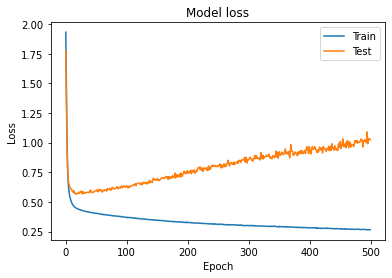

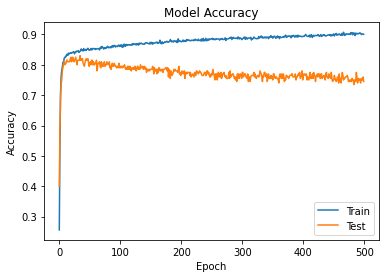

In [33]:
plot_loss_accuracy(history)

We clearly see that the number of epochs we choose has a great influence on the final results: 
- If not enough epochs, then the algorithm is not optimal as it has not converged yet. 
- On the other hand, if too many epochs, we overfit the training data and the algorithm does not generalize well on test data.

What we want is basically to stop the algorithm when the test loss is minimal (or the test accuracy is maximal).

Let's introduce the early stopping criterion which is a way to stop the epochs of the algorithm at a interesting epoch. It basically use part of the data to see if the test loss stops from improving. You cannot use the test data to check that, otherwise, it is some sort of data leakage. On the contrary, it uses a subset of the initial training data, called the **validation set**

It basically looks like the following : 

<img src="validation_set.png" alt="Validation set" style="height:350px;"/>

To split this data, we use, in the `fit` function, the `validation_split` keywork which sets the percentage of data from the initial training set used in the validation set. On top of that, we use the `callbacks` keyword to call the early stopping criterion at the end of each epoch. You can check additional information in the [documentation](https://www.tensorflow.org/guide/keras/train_and_evaluate)


❓ **Question** ❓ Launch the following code, plot the history and evaluate it on the test set

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping()

model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=500,
                    batch_size=16, 
                    verbose=0, 
                    callbacks=[es])

def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

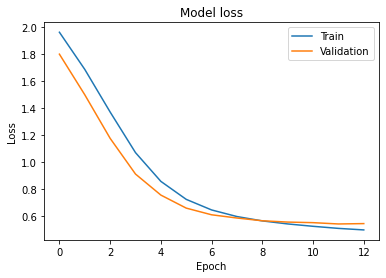

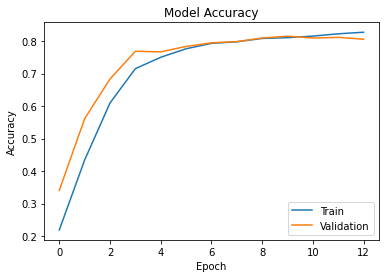

In [40]:
plot_loss_accuracy(history)

In [41]:
print('accuracy = ', model.evaluate(X_test, y_test)[1])

7/7 [==============================] - 0s 1ms/step - loss: 0.5893 - accuracy: 0.7950
accuracy =  0.7950000166893005


❗ **Remark** ❗ The problem, with this type of approach, is that as soon as the loss of the validation set increases, the model stops. However, as neural network convergence is stochastic, it happens that the loss increases before decreasing again. For that reason, the Early Stopping criterion has the `patience` keyword that defines how many epochs without loss decrease you allow.

❓ **Question** ❓ Use the early stopping criterion with a patience of 30 epochs, plot the results and print the accuracy on the test set

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 30)

model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=500,
                    batch_size=16, 
                    verbose=0, 
                    callbacks=[es])

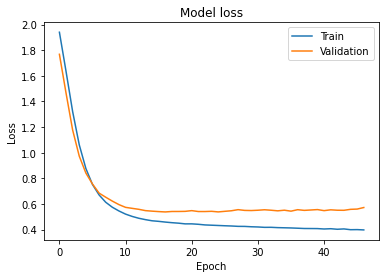

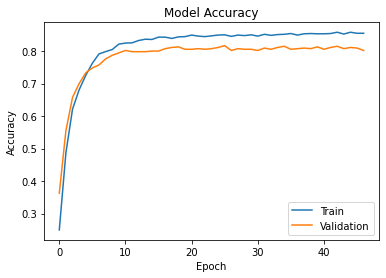

In [47]:
plot_loss_accuracy(history)

In [48]:
print('accuracy = ', model.evaluate(X_test, y_test)[1])

7/7 [==============================] - 0s 1ms/step - loss: 0.5918 - accuracy: 0.8050
accuracy =  0.8050000071525574


❗ **Remark** ❗ You now see that the model continue to converge even though it has some loss increase and descrease. The number of patience epochs to select is highly related to the task at hand and there does not exist any general rule. 

❗ **Remark** ❗ In case you select a high patience, you might face the problem that the loss on the test set decrease a lot from the best position. To that end, the early stopping criterion allows you to stop the convergence _and_ restore the weights of the neural network when it had the best score on the validation set, thanks to the `restore_best_weights` that is set to `False` by default.

❓ **Question** ❓ Run the model with a early stopping criterion that enables to restore the best weights of the parameters, plot the loss and accuracy and print the accuracy on the test set

In [49]:
es = EarlyStopping(patience=30, restore_best_weights=True)

model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=500,
                    batch_size=16, 
                    verbose=0, 
                    callbacks=[es])

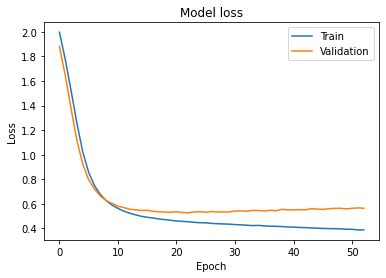

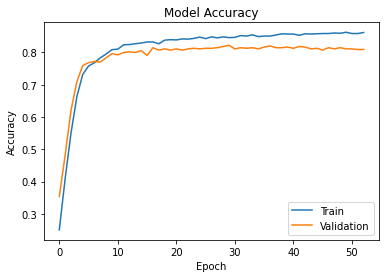

In [52]:
plot_loss_accuracy(history)

In [51]:
print('accuracy = ', round(model.evaluate(X_test, y_test)[1],2))

7/7 [==============================] - 0s 1ms/step - loss: 0.5765 - accuracy: 0.8200
accuracy =  0.82


❗ **Remark 1** ❗ You can look at the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to play with other parameters

❗ **Remark 2** ❗ No need to take a look at the epochs as long as it hit the stopping criterion. So, in the future, you should have a large number of epochs and the early stopping criterion has to stop the epochs. 

❓ **Question** ❓ If you look closely at the different plots, you might see that sometimes, between two epochs, the loss is different but the accuracy is the same. How can that happend?

Hint : look at the following class and two different predictions. What would the accuracy and loss be in the two cases?

In [ ]:
# True label
y_true = 1

# Prediction 1
y_pred_1 = 0.55

# Prediction 2
y_pred_2 = 0.99

In [53]:
# The loss would be higher with y_pred_1 but both would lead to the same accuracy

# Part III : Batch-size & Epochs

❓ **Question** ❓ Run the previous model with different batch sizes (with the early stopping criterion)  and plot the results.

In [54]:
es = EarlyStopping(patience=30, restore_best_weights=True)

model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=500,
                    batch_size=25, 
                    verbose=0, 
                    callbacks=[es])

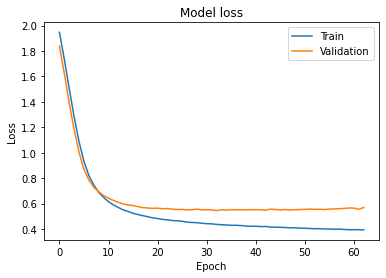

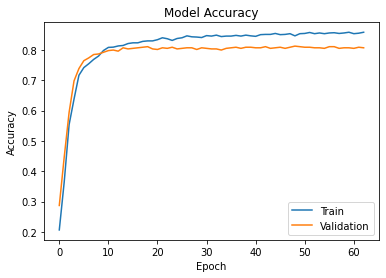

In [55]:
plot_loss_accuracy(history)

In [56]:
print('accuracy = ', round(model.evaluate(X_test, y_test)[1],2))

7/7 [==============================] - 0s 964us/step - loss: 0.5985 - accuracy: 0.8050
accuracy =  0.81


In [62]:
es = EarlyStopping(patience=30, restore_best_weights=True)

model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=500,
                    batch_size=2, 
                    verbose=0, 
                    callbacks=[es])

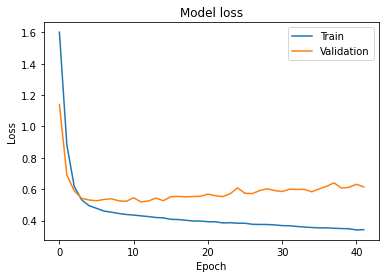

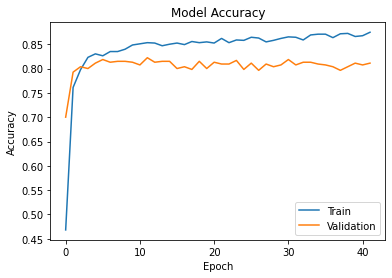

In [63]:
plot_loss_accuracy(history)

In [64]:
print('accuracy = ', round(model.evaluate(X_test, y_test)[1],2))

7/7 [==============================] - 0s 1ms/step - loss: 0.5649 - accuracy: 0.8100
accuracy =  0.81


❓ **Question** ❓ Look at the oscillations of the accuracy and loss with respect to the batch size number. Is this coherent with what we saw with the Tensorflow Playground? 

Yes, small batch size leads to oscillations.